<a href="https://colab.research.google.com/github/kimtaehyuk1/AI_Project/blob/master/%EB%AA%A8%EB%93%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B82_%EB%B6%84%EB%A5%98_%EA%B0%9C%EB%B0%9C%EB%85%B8%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 연구목표 - 범주형 데이터 이진분류 경진대회

- https://www.kaggle.com/competitions/playground-series-s3e2



# 데이터 획득 및 파악

- test 데이터를 예측해서 submission의 target 컬럼에 채운다
- 기본값으로 모두 0.041296로 세팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import sparse
%matplotlib inline

In [ ]:
path = '/content/drive/MyDrive/파트2_모듈프로젝트_데이터/'

train_path = f'{path}train.csv'
test_path = f'{path}test.csv'
sample_submission_path = f'{path}sample_submission.csv'
healthcare_dataset_stroke_data = f'{path}healthcare_dataset_stroke_data.csv'

train = pd.read_csv(train_path, index_col='id')
test = pd.read_csv(test_path, index_col='id')
sample_submission = pd.read_csv(sample_submission_path, index_col = 'id')
healthcare_dataset_stroke_data = pd.read_csv(healthcare_dataset_stroke_data, index_col = 'id')


In [ ]:
train.head(2).T

id,0,1
gender,Male,Male
age,28.0,33.0
hypertension,0,0
heart_disease,0,0
ever_married,Yes,Yes
work_type,Private,Private
Residence_type,Urban,Rural
avg_glucose_level,79.53,78.44
bmi,31.1,23.9
smoking_status,never smoked,formerly smoked


In [ ]:
test.head(2).T

id,15304,15305
gender,Female,Male
age,57.0,70.0
hypertension,0,1
heart_disease,0,0
ever_married,Yes,Yes
work_type,Private,Private
Residence_type,Rural,Urban
avg_glucose_level,82.54,72.06
bmi,33.4,28.5
smoking_status,Unknown,Unknown


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 15304 to 25507
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10204 non-null  object 
 1   age                10204 non-null  float64
 2   hypertension       10204 non-null  int64  
 3   heart_disease      10204 non-null  int64  
 4   ever_married       10204 non-null  object 
 5   work_type          10204 non-null  object 
 6   Residence_type     10204 non-null  object 
 7   avg_glucose_level  10204 non-null  float64
 8   bmi                10204 non-null  float64
 9   smoking_status     10204 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 876.9+ KB


In [ ]:
train.shape, test.shape, sample_submission.shape

((15304, 11), (10204, 10), (10204, 1))

In [ ]:
sample_submission.head(), sample_submission.stroke.unique()

(         stroke
 id             
 15304  0.041296
 15305  0.041296
 15306  0.041296
 15307  0.041296
 15308  0.041296, array([0.04129639]))

In [ ]:
def summary_feature_info( df, train=train ):
    '''
      # 피처 요약 정보 생성하는 함수 구성
      # 전체 데이터 : 볼륨(형상) -> print()
      # 피처별 : 피처명, 타입,  결측치수, 고유값수, 샘플값0~2(0,1,2개정도) => DF로 구성 출력
      # 피처를 파악해 보겠다
    '''
    sum_df = pd.DataFrame( train.dtypes, columns=['type'] )
    # 인덱스 -> 컬럼으로 이동
    sum_df = sum_df.reset_index()
    # 칼럼명 inde -> feature_name 변경
    sum_df.rename( columns={ 'index':'feature_name' }, inplace=True )
    
    # 결측치수
    sum_df['결측치수'] = train.isnull().sum().values  # 피처별 결측 개수 구하기

    # 고유값수
    sum_df['고유값수'] = train.nunique().values       # 피처별 고유값 개수 구하기 
    
    # 샘플0~2(0,1,2개정도)
    sum_df['샘플값0'] = train.loc[0].values
    sum_df['샘플값1'] = train.loc[1].values
    sum_df['샘플값2'] = train.loc[2].values

    return sum_df

summary_df = summary_feature_info( train )
summary_df

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,gender,object,0,3,Male,Male,Female
1,age,float64,0,106,28.0,33.0,42.0
2,hypertension,int64,0,2,0,0,0
3,heart_disease,int64,0,2,0,0,0
4,ever_married,object,0,2,Yes,Yes,Yes
5,work_type,object,0,5,Private,Private,Private
6,Residence_type,object,0,2,Urban,Rural,Rural
7,avg_glucose_level,float64,0,3740,79.53,78.44,103.0
8,bmi,float64,0,407,31.1,23.9,40.3
9,smoking_status,object,0,4,never smoked,formerly smoked,Unknown


In [ ]:
train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
test.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

# 피처 요약

## 이진형

  - gender
    - 범주형-명목형 => 이진형으로 분류 예정
    - 고유값3 Male, Female, Otheer
    - other가 train, test 모두 하나씩있다
    - 최빈값(train,test의 최빈값이 다르다면 train기준으로도 각각으로도 ok)->최빈값 Female로 처리
  - hypertension     이진
  - heart_disease    이진
  - ever_married     이진
  - Residence_type   이진

In [ ]:
# bin_data = 이진형으로 사용할 데이터
bin_data = summary_df.loc[[0, 2, 3, 4, 6]].reset_index(drop=True)
bin_data

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,gender,object,0,3,Male,Male,Female
1,hypertension,int64,0,2,0,0,0
2,heart_disease,int64,0,2,0,0,0
3,ever_married,object,0,2,Yes,Yes,Yes
4,Residence_type,object,0,2,Urban,Rural,Rural


In [ ]:
# train 고유값 확인
print(train['gender'].unique())
print(train['hypertension'].unique())
print(train['heart_disease'].unique())
print(train['ever_married'].unique())
print(train['Residence_type'].unique())

['Male' 'Female' 'Other']
[0 1]
[0 1]
['Yes' 'No']
['Urban' 'Rural']


In [ ]:
# test 고유값 확인
print(test['gender'].unique())
print(test['hypertension'].unique())
print(test['heart_disease'].unique())
print(test['ever_married'].unique())
print(test['Residence_type'].unique())

['Female' 'Male' 'Other']
[0 1]
[0 1]
['Yes' 'No']
['Rural' 'Urban']


In [ ]:
# train['gender']에 other 1개 확인
train.value_counts('gender').sort_index()

gender
Female    9446
Male      5857
Other        1
dtype: int64

In [ ]:
# test['gender']에 other 1개 확인
test.value_counts('gender').sort_index()

gender
Female    6338
Male      3865
Other        1
dtype: int64

## 범주형-명목형

- work_type          범주형-명목형 4
- smoking_status     범주형-명목형

In [ ]:
# nom_data는 순서없는 명목형으로 처리
nom_data = summary_df.loc[[5,9]].reset_index(drop=True)
nom_data

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,work_type,object,0,5,Private,Private,Private
1,smoking_status,object,0,4,never smoked,formerly smoked,Unknown


In [ ]:
train.value_counts('work_type').sort_index()

work_type
Govt_job         1533
Never_worked       42
Private          9752
Self-employed    1939
children         2038
dtype: int64

In [ ]:
test.value_counts('work_type').sort_index()

work_type
Govt_job          992
Never_worked       20
Private          6573
Self-employed    1349
children         1270
dtype: int64

In [ ]:
train.value_counts('smoking_status').sort_index()

smoking_status
Unknown            4543
formerly smoked    2337
never smoked       6281
smokes             2143
dtype: int64

In [ ]:
test.value_counts('smoking_status').sort_index()

smoking_status
Unknown            2976
formerly smoked    1584
never smoked       4237
smokes             1407
dtype: int64

## 연속형_수치형 피처
  - avg_glucose_level
  - bmi               
  - age
    - 'avg_glucose_level, 'bmi'는 범주형-순서형으로 처리했을 때와 그냥 스케일링 했을 때와 결과 차이 비교 => 제출 결과 연속형 수치는 순서형으로 처리하지 않고 그대로 스케일링하여 학습시켰을 때 높은 성능 결과가 나왔다 

In [ ]:
# nom_data2는 순서형 명목형으로 처리
nom_data2 = summary_df.loc[[1,7,8]].reset_index(drop=True)
nom_data2
# avg_glucose_level, bmi는 연속형수치

,feature_name,type,결측치수,고유값수,샘플값0,샘플값1,샘플값2
0,age,float64,0,106,28.0,33.0,42.0
1,avg_glucose_level,float64,0,3740,79.53,78.44,103.0
2,bmi,float64,0,407,31.1,23.9,40.3


# 데이터 EDA 분석 및 피처 엔지니어링 대상체크

## stroke값 분포

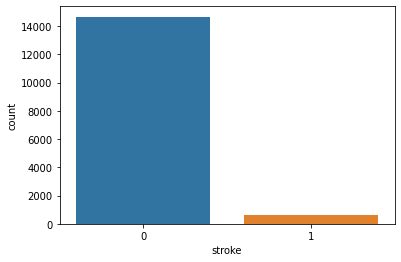

In [ ]:
sns.countplot( data=train, x='stroke' );

In [ ]:
c0, c1 = np.unique( train.stroke.values,  return_counts=True)[1]
c0 / c1
# stroke값 1에 비해 0은 23.215배 많이 분포한다 

23.21518987341772

타겟값간 비율 23.21518987341772


Text(0.5, 1.0, 'Target Value Distribution')

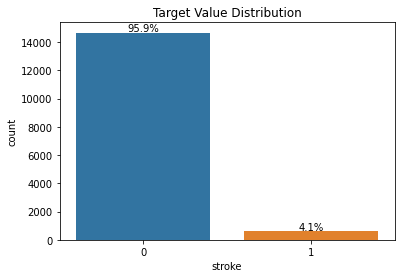

In [ ]:
# 향후 시각화 자료에 비율을 표기하는 부분을 추가 => 텍스트 드로잉
def show_text_percent_by_stroke( ax, total_count, is_show=True,  ):
  '''
    is_show : True일대만 텍스트가 노출되게 처리
    ax : 텍스트를 그리고자 하는 차트의 축정보
    total_count : 전체 카운트수
  '''
  persents = list()         # 비율을 담는 그릇
  # 카운트 플롯 차트상에 개별 박스 정보를 구하는 방법 -> ax.patches

  # 카운트 플롯 차트상에서 순차적으로 박스를 하나식 추출한다
  for patch in ax.patches:     # 차트상에 존재하는 모든 형태의 도형을 차례대로 추출하는 연속형 변수
    w = patch.get_width()      # 타겟값 0 혹은 1, 카운트 플롯의 개별 박스 너비
    h = patch.get_height()     # 타겟값 0 혹은 1의 카운트수 -> 카운트 플롯의 개별 박스 높이->카운트
    p = h/total_count * 100    # 타깃값의 비율 = (개별박스의 높이(카운트) / 전체카운트)*100
    persents.append( p )
    # 텍스트 그리기
    # 좌표 정보 획득
    l = patch.get_x()         # 도형 왼쪽 테투리 X축의 기준 위치값    
    ax.text(  x=l + w/2,      # 도형의 정 가운데를 X축 좌표
              y=h + total_count*0.005, # 1, total_count(가변값)의 특정 비율로 올려서 위치를 조정
              s=f'{p:1.1f}%', # 타겟값의 비율을 개별 차트내 도형 위에 그려지는 내용 ex) 38.8%
              ha='center'     # 정렬(가운데)
            )
  if is_show:
    if len(persents) == 2:   # 타겟용
      print( '타겟값간 비율', persents[0]/persents[1] )
    elif len(persents) == 4: # 이진 피처용
      print( persents )
      # 타겟값에 맞춰서 도형이 그려진다 0번 타겟이 먼저 그려지고, 1번 타겟이 나중에 그려진다
      print( persents[0]/persents[2], persents[1]/persents[3] )
      
  pass

ax = sns.countplot( data=train, x='stroke');
show_text_percent_by_stroke( ax, train.shape[0] )
ax.set_title('Target Value Distribution')

## 현재 이진형인 데이터

- 'hypertension', 'heart_disease', 'ever_married', 'Residence_type'

[91.73418714061683, 4.13617354939885, 3.293256664924203, 0.836382645060115]
27.855158730158724 4.945312500000001


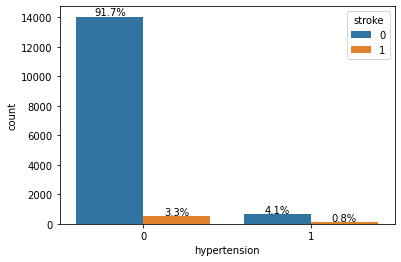

[93.96889702038683, 1.9014636696288552, 3.698379508625196, 0.43125980135912184]
25.40812720848057 4.409090909090908


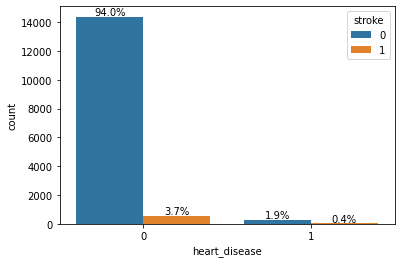

[63.99634082592787, 31.87401986408782, 3.8617354939884994, 0.2679038159958181]
16.57191201353638 118.97560975609757


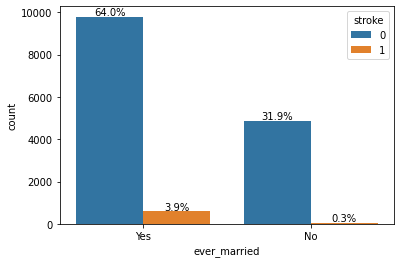

[47.86330371144798, 48.0070569785677, 2.0582854155776267, 2.071353894406691]
23.253968253968253 23.176656151419557


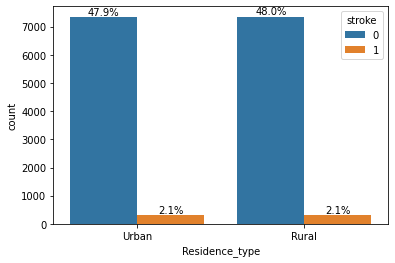

In [ ]:
bin = ['hypertension', 'heart_disease', 'ever_married', 'Residence_type']

for i in bin:
    ax = sns.countplot( data=train, x=i, hue='stroke' );
    show_text_percent_by_stroke( ax, train.shape[0] )
    #ax.set_title(f'{ bin }\'s Value Distribution')
    plt.show();

# stroke값 1에 비해 0은 23.215배 많이 분포한다 
# 피처 간의 고유값별 타겟값 비율이 상이하다 -> 학습에 도움이 된다

## 현재 범주형-명목형인 데이터

- 'gender', 'work_type', 'smoking_status'

### 데이터 교차 분석표
- cross-tabulation (교차분석표)
  - 범주형 데이터 2개를 분석할때 사용되는 표
  - 범주형 데이터의 빈도/통계량을 행렬로 결합한 표
  - **명목형 피처 단위의 정답 1에 대한 비율을 표현하기 위해 사용**


In [ ]:
pd.crosstab( train['gender'], train['stroke'] )

stroke,0,1
gender,,
Female,9078,368
Male,5593,264
Other,1,0


In [ ]:
# 백분율로 표현
# normalize 옵션 지정 => index or column을 지정하면 해당 기준으로 백분율 처리
cross_tab = pd.crosstab( train['gender'], train['stroke'], normalize='index' ) * 100
cross_tab

stroke,0,1
gender,,
Female,96.104171,3.895829
Male,95.492573,4.507427
Other,100.000000,0.000000


In [ ]:
# 인덱스 -> 컬럼으로 이동
cross_tab.reset_index( inplace=True )
cross_tab
# strsoke값 비율에 아래 값들은 전반적으로 유사한 비율을 가지고 있다
# other값은 한개여서 100:0의 비율이 나타났다

stroke,gender,0,1
0,Female,96.104171,3.895829
1,Male,95.492573,4.507427
2,Other,100.000000,0.000000


In [ ]:
# 함수화하여 아래 시각화에서 crosstab함수 사용
def make_cross_tab( df , feature_name ):
  cross_tab = pd.crosstab( df[feature_name], train['stroke'], normalize='index' ) * 100
  cross_tab.reset_index( inplace=True )
  return cross_tab

cross_tab = make_cross_tab( train, 'gender' )
cross_tab

stroke,gender,0,1
0,Female,96.104171,3.895829
1,Male,95.492573,4.507427
2,Other,100.000000,0.000000


In [ ]:
# 'gender'에서 stroke값 비율 추출
cross_tab[1]

0    3.895829
1    4.507427
2    0.000000
Name: 1, dtype: float64

### 포인트 플롯 


- 정답 1에 대한 비율 포인트를 찍고, 포인트를 연결
- 이것을 통해 추세를 확인, **차이 확인(구분이되는가)**

In [ ]:
cross_tab.columns

Index(['gender', 0, 1], dtype='object', name='stroke')

In [ ]:
def show_pointplot( feature, cross_tab, color, ax=None ):
  if ax:
    sns.pointplot(   x=feature,             # 피처값
                  y=1,            # 정다 1에 대한 포인트 플롯
                  data=cross_tab, # 그리는 대상 df
                  order=cross_tab[feature],     # 포인트플롯 순서
                  color=color,    # 그리는 색상
                  ax=ax
                  );
show_pointplot( 'gender', cross_tab, 'red' )

[29.685049660219548, 15.27051751176163, 41.041557762676426, 14.002875065342394]
0.723292469352014 1.0905272981801213


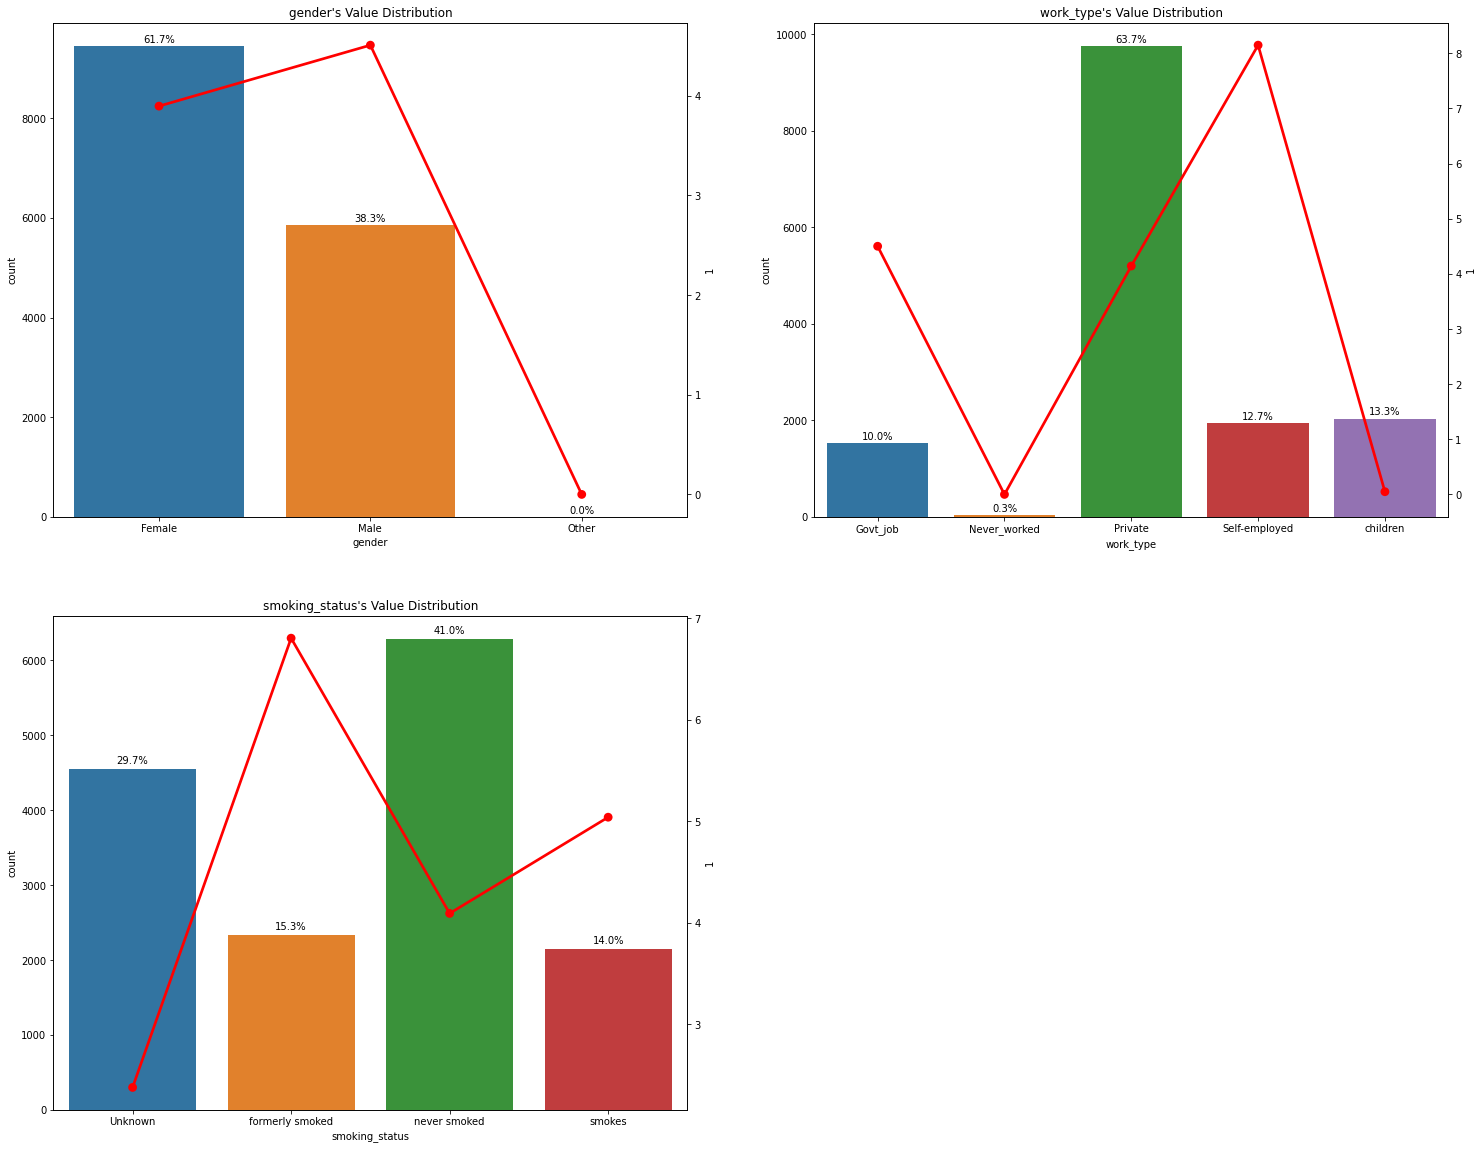

In [ ]:
nom = ['gender', 'work_type', 'smoking_status']

def show_count_point_plot( all_data, features, rows=2, cols=2 ):
  # 1개의 차트에 격자로 분할 -> 각 자리에 ax를 전달, 이것을 이용하여 그린다
  plt.figure( figsize=(25, 20) ) # 그리면서 조정 : 세로 2칸, 가로 2칸
  # 서브플롯 배치 
  p_grid = gridspec.GridSpec(rows, cols)  # 3줄, 2칸 => 차트 5개 => 피처가 5개

  for i,feature in enumerate( features ):
    ax = plt.subplot( p_grid[i] )
    cross_tab = make_cross_tab( all_data, feature )
    # order를 사용 했으면 한차트에 사용되는 모든 함수는 같은 순서(order) 유지 해야 동일하게 배치됨
    sns.countplot( data=all_data, x=feature, ax=ax, order=cross_tab[feature] )  # ax=ax : 격자 안에서 특정 위치로 차트가 세팅
    show_text_percent_by_stroke( ax, all_data.shape[0] )
    ax.set_title(f'{ feature }\'s Value Distribution')
    show_pointplot( feature, cross_tab, 'red', ax.twinx() )
  plt.show()  

show_count_point_plot( train, nom )
# 고유값별로 등장 빈도가 다르다 => 학습에 도움이 된다 (구분이 된다)

## 연속형-수치형 데이터
- `'avg_glucose_level, 'bmi', 'age'는 범주형-순서형으로 처리하여 시각화 분석 및 학습 진행`

- 바로 스케일링하여 학습했을 때와 결과 차이 비교 => 제출 결과 연속형 수치는 순서형으로 처리하지 않고 그대로 스케일링하여 학습시켰을 때 높은 성능 결과가 나왔다

- 최종결과에는 범주형-순서형으로 변환하여 사용하지 않았으므로 'avg_glucose_level, 'bmi', 'age'을 범주형-순서형으로 처리하는 과정코드는 주석으로만 첨부하였다

### 'avg_glucose_level, 'bmi', 'age' 데이터 연속형수치형으로  EDA 분석


In [ ]:
def data_visualizer(data, features, mode='hist'):
    '''
    mode: 'hist' or 'reg' , 'heat'
    '''
    import math

    if mode == 'heat':
        sns.heatmap( data[ features ].corr(), annot=True );
        return 0

    cols = 2
    rows = math.ceil(len(features) / cols )

    fig, ax = plt.subplots( ncols=cols, nrows=rows, figsize=(15,20) )

    if mode == 'hist':
        for i, feature in enumerate(features):
            sns.distplot(data[feature], ax=ax[math.floor(i/cols)][i%cols]);
    
    elif mode == 'reg':
        for i, feature in enumerate(features):
            sns.regplot(data=data, x = feature,y='stroke' ,ax=ax[math.floor(i/cols)][i%cols], line_kws={'color':'red'}, scatter_kws={'alpha':0.5});
    
    else:
        pass

    plt.show()

    return 0

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

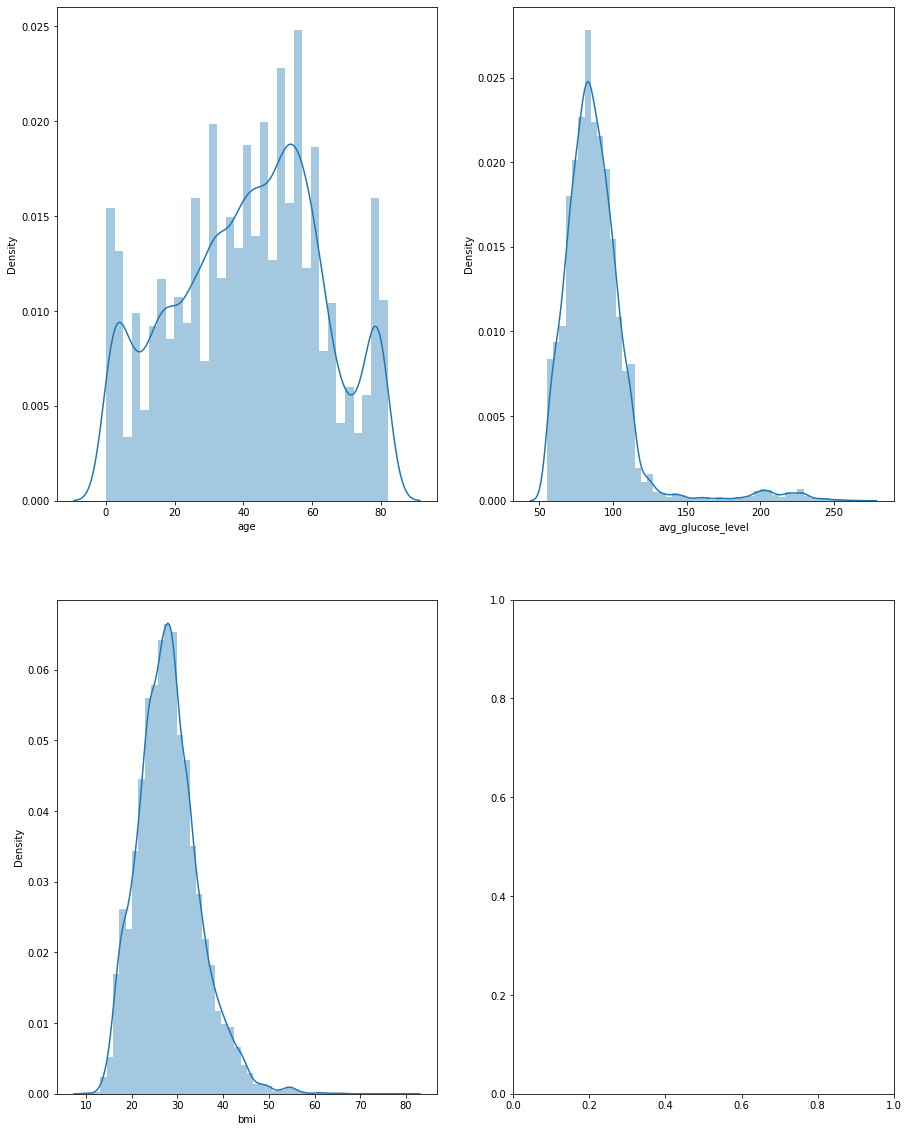

0

In [ ]:
# 히스토그램
data_visualizer(train, ['age', 'avg_glucose_level', 'bmi'])

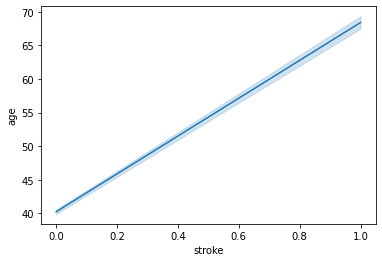

In [ ]:
# age 비율
sns.lineplot(data=train, y='age', x='stroke')

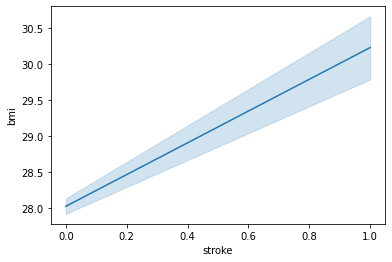

In [ ]:
sns.lineplot(data=train, y='bmi', x='stroke')

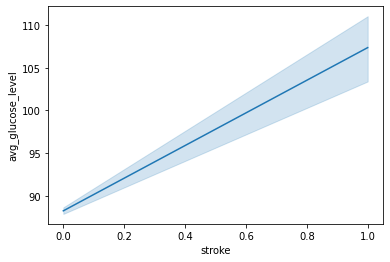

In [ ]:
sns.lineplot(data=train, y='avg_glucose_level', x='stroke')

### 'avg_glucose_level, 'bmi', 'age' 데이터를 범주형-순서형으로 처리하여 데이터 EDA 2차 분석
- 다음과 같이 범주형-순서형으로 처리하여 EDA분석 캡처하여 첨부
- avg_glucose_level : 'Normal', 'Prediabetic', 'Diabetic' 

- bmi : 'Underweight', 'Normal', 'Overweight', 'Obsese'

- age : 'minor', 'the_youth', 'middle_aged', 'the_eldery'

- 당뇨병이 없는 혈당수치가 정상인 경우와 당뇨병전단계에서는 뇌졸중 타겟값 비율이 낮게 나온다
- 당뇨병 환자인 경우 뇌졸중 타겟값 비율이 매우 높게 나타났다 => 당뇨병과 뇌졸중 간의 관계가 있음을 생각할 수 있다
- bmi지수가 높을수로 뇌졸중 타겟값 비율이 높게 나타났다
- 나이가 고령일수록 뇌졸중 타겟값 비율이 높게 나타났다

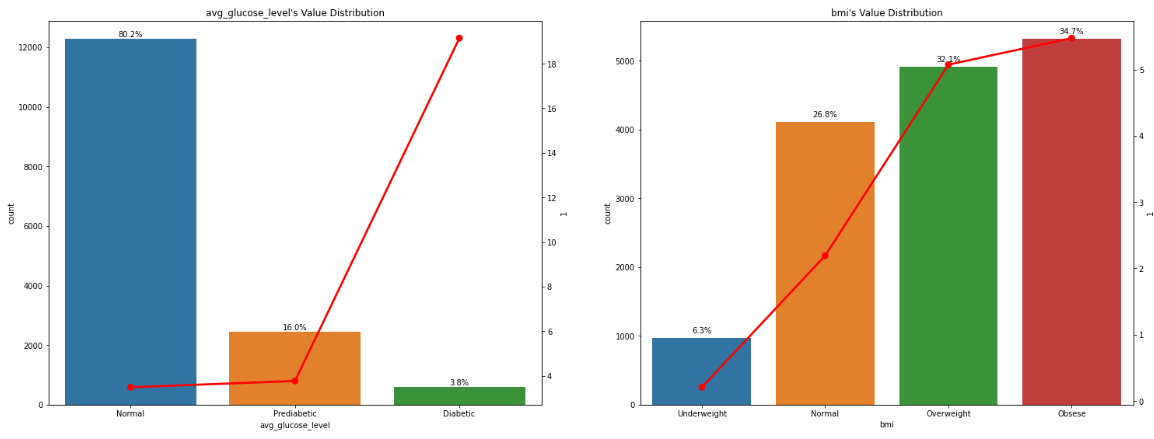

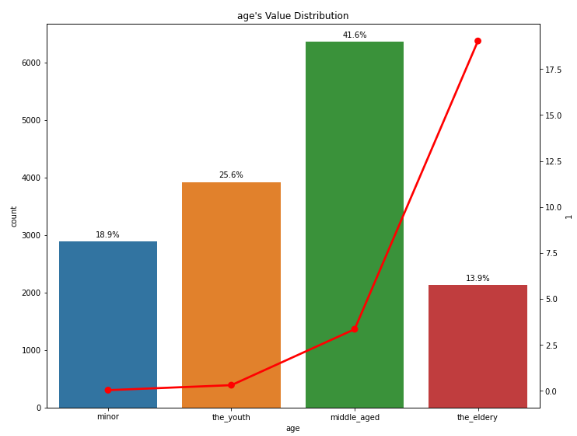

In [ ]:
# 정상-당뇨병전단계-당뇨병 발병단계별로 뇌졸중일 확률에 차이가 있을지 알아보고자 범주형순서형으로 전환하여 학습시켜보고자 하였다
# test도 똑같이 처리하여 학습을 진행했다
'''
# avg_glucose_level 4단계분류 - train
new_avg_glucose_level = []
for row in train['avg_glucose_level']:
  if row  >= 126:
    new_avg_glucose_level.append('Diabetic')
  elif row >= 100:
    new_avg_glucose_level.append('Prediabetic')
  else:
    new_avg_glucose_level.append('Normal')

train['avg_glucose_level'] = new_avg_glucose_level
'''

"\n# avg_glucose_level 4단계분류 - train\nnew_avg_glucose_level = []\nfor row in train['avg_glucose_level']:\n  if row  >= 126:\n    new_avg_glucose_level.append('Diabetic')\n  elif row >= 100:\n    new_avg_glucose_level.append('Prediabetic')\n  else:\n    new_avg_glucose_level.append('Normal')\n\ntrain['avg_glucose_level'] = new_avg_glucose_level\n"

In [ ]:
# 체질량 지수가 뇌졸중과 연관이 있는지 알아보고자 범주형 순서형 데이터로 전환하여 학습시켜보고자 하였다
# test도 똑같이 처리하여 학습을 진행했다
'''
# bmi 4단계로 분류-train
new_bmi = []
for row in train['bmi']:
  if row  >= 30:
    new_bmi.append('Obsese')
  elif row >= 25:
    new_bmi.append('Overweight')
  elif row >= 18.5:
    new_bmi.append('Normal')
  else:
    new_bmi.append('Underweight')

train['bmi'] = new_bmi
'''

"\n# bmi 4단계로 분류-train\nnew_bmi = []\nfor row in train['bmi']:\n  if row  >= 30:\n    new_bmi.append('Obsese')\n  elif row >= 25:\n    new_bmi.append('Overweight')\n  elif row >= 18.5:\n    new_bmi.append('Normal')\n  else:\n    new_bmi.append('Underweight')\n\ntrain['bmi'] = new_bmi\n"

In [ ]:
# 나이가 뇌졸중과 연관이 있는지 알아보고자 범주형 순서형 데이터로 전환하여 학습시켜보고자 하였다
# test도 똑같이 처리하여 학습을 진행했다
'''
# age 4단계로 분류-train
new_age = []
for row in train['age']:
  if row  >= 65:
    new_age.append('the_eldery')
  elif row >= 40:
    new_age.append('middle_aged')
  elif row >= 20:
    new_age.append('the_youth')
  else:
    new_age.append('minor')

train['age'] = new_age
'''

"\n# age 4단계로 분류-train\nnew_age = []\nfor row in train['age']:\n  if row  >= 65:\n    new_age.append('the_eldery')\n  elif row >= 40:\n    new_age.append('middle_aged')\n  elif row >= 20:\n    new_age.append('the_youth')\n  else:\n    new_age.append('minor')\n\ntrain['age'] = new_age\n"

In [ ]:
# 'avg_glucose_level, 'bmi', 'age' 데이터를 범주형-순서형으로 처리하여 시각화 분석 및 학습 진행
'''
# 피처 순서 지정 처리
from pandas.api.types import CategoricalDtype

ord = ['avg_glucose_level', 'bmi', 'age']
# 새로 순서 셋팅
ord_1 = [ 'Normal', 'Prediabetic', 'Diabetic' ]
ord_2 = [ 'Underweight', 'Normal', 'Overweight', 'Obsese' ]
ord_3 = [ 'minor', 'the_youth', 'middle_aged', 'the_eldery' ]
# 순서 생성
ord_1_dtype = CategoricalDtype(ord_1, True)
ord_2_dtype = CategoricalDtype(ord_2, True)
ord_3_dtype = CategoricalDtype(ord_3, True)

# 순서 적용 -> Dtype 적용
train['avg_glucose_level'] = train['avg_glucose_level'].astype(ord_1_dtype)
train['bmi'] = train['bmi'].astype(ord_2_dtype)
train['age'] = train['age'].astype(ord_3_dtype)
def show_count_point_plot( all_data, features, rows=2, cols=2 ):
  # 1개의 차트에 격자로 분할 -> 각 자리에 ax를 전달, 이것을 이용하여 그린다
  plt.figure( figsize=(25, 20) )
  # 서브플롯 배치 
  p_grid = gridspec.GridSpec(rows, cols)  

  for i,feature in enumerate( features ):
    ax = plt.subplot( p_grid[i] )
    cross_tab = make_cross_tab( all_data, feature )
    # order를 사용 했으면 한차트에 사용되는 모든 함수는 같은 순서(order) 유지 해야 동일하게 배치됨
    sns.countplot( data=all_data, x=feature, ax=ax, order=cross_tab[feature] )  # ax=ax : 격자 안에서 특정 위치로 차트가 세팅
    show_text_percent_by_stroke( ax, all_data.shape[0] )
    ax.set_title(f'{ feature }\'s Value Distribution')
    show_pointplot( feature, cross_tab, 'red', ax.twinx() )
  plt.show()  

show_count_point_plot( train, ord )
'''

"\n# 피처 순서 지정 처리\nfrom pandas.api.types import CategoricalDtype\n\nord = ['avg_glucose_level', 'bmi', 'age']\n# 새로 순서 셋팅\nord_1 = [ 'Normal', 'Prediabetic', 'Diabetic' ]\nord_2 = [ 'Underweight', 'Normal', 'Overweight', 'Obsese' ]\nord_3 = [ 'minor', 'the_youth', 'middle_aged', 'the_eldery' ]\n# 순서 생성\nord_1_dtype = CategoricalDtype(ord_1, True)\nord_2_dtype = CategoricalDtype(ord_2, True)\nord_3_dtype = CategoricalDtype(ord_3, True)\n\n# 순서 적용 -> Dtype 적용\ntrain['avg_glucose_level'] = train['avg_glucose_level'].astype(ord_1_dtype)\ntrain['bmi'] = train['bmi'].astype(ord_2_dtype)\ntrain['age'] = train['age'].astype(ord_3_dtype)\ndef show_count_point_plot( all_data, features, rows=2, cols=2 ):\n  # 1개의 차트에 격자로 분할 -> 각 자리에 ax를 전달, 이것을 이용하여 그린다\n  plt.figure( figsize=(25, 20) )\n  # 서브플롯 배치 \n  p_grid = gridspec.GridSpec(rows, cols)  \n\n  for i,feature in enumerate( features ):\n    ax = plt.subplot( p_grid[i] )\n    cross_tab = make_cross_tab( all_data, feature )\n    # order를 사용 했으면 한차

# 조원별로 EDA 분석 및 다른 방법으로 각자 학습진행

## 박소훈 - 연속형 데이터 피처들을 순서형으로 변환하여 XGBoost학습-> private 0.87383


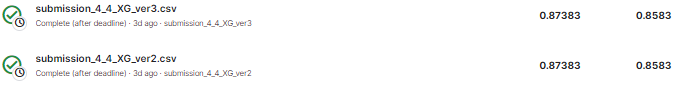

## 이지원 - 연속형 데이터 피처들을 그대로 스케일링하여 XGBoost학습-> private 0.884

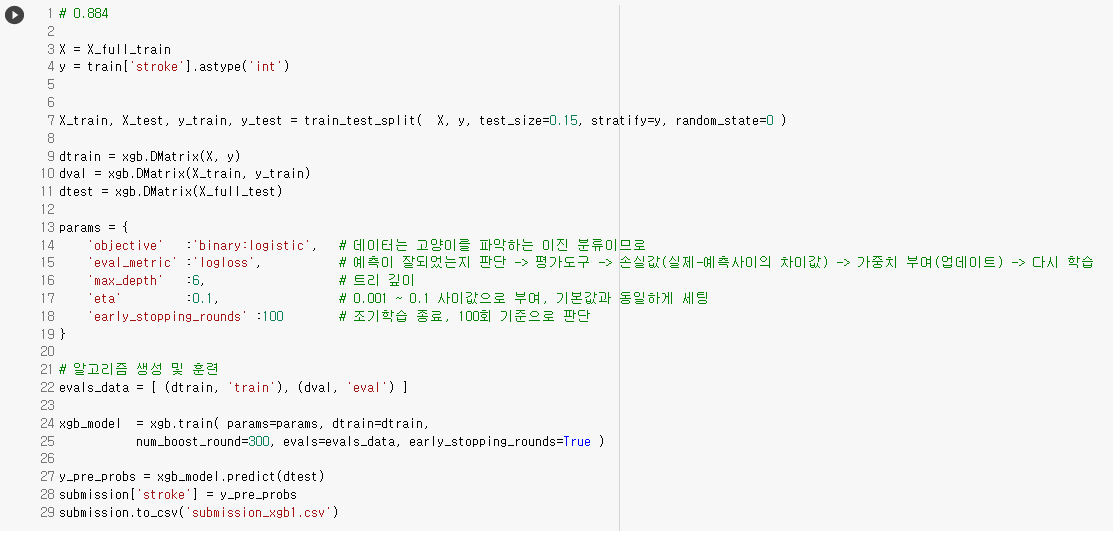

# 조원별 학습 결과 공유를 통한 모델 구축 과정 및 이후 진행과정 설명
- 연속형수치인 피처들은 순서형으로 변환하지 않고 그대로 스케일링하여 학습하는 것이 학습성능이 높게 나왔다
- 피처의 고유값별 정답값1인 데이터의 비율이 기존 train데이터에 부족하다고 판단
  - 캐글의 해당 에피소드 원본데이터 중 stroke 값이 1인 데이터를 불러와 병합 -> 학습성능 향상에 도움이 될거라 예측
-  XGBoost 모델 선정 
  - 조원 모두 XGBoost 모델의 결과가 좋았다
  - 원본데이터에는 결측치가 존재 -> XGBoost 모델이 결측치를 자동 처리해주므로  XGBoost 모델로 진행하기로 결정
- 베이지안 최적화를 통해 최적의 하이퍼파라미터를 추출
- 모든 모델의 조합으로 우선 K-Fold교차검증을 진행
  - 검증 결과를 통한 점수를 내림차순으로 정렬하여 상위100개 조합을 엑셀에 저장
  - 상위100개 중 높은 빈도의 데이터 엔지니어링 방법을 추출(ex) work_type3 / smoking2 or 3 ) -> 여기서 20개의 조합이 생성
- 20개의 조합을 전부 제출하여 조원 개인이했던 결과보다 학습결과가 향상되었는지 확인
- 다시 처음부터 위의 데이터 모델들의 조합으로 1차로 선정한 파라미터 값으로 약 1000개의 조합으로 학습 및 파일생성 제출 진행
- 위의 과정 진행 중 베이지안 최적화로 얻은 하이퍼 파라미터값을 수정하며 조원별로 성능 높이기 시도
- 한 조원이 찾은 더 높은 성능 결과의 파라미터값으로 수정하여 1000개의 조합을 재학습, 제출하여 최종 Private Score 0.90044를 달성



---



# 원본데이터 중 stroke1인 데이터 train데이터에 합치기

In [ ]:
# 원본데이터에서 스트로크값이 1인 것만 가져와서 트레인과 합함, 1에 대한 값이 적어 1에 대한 가지수를 높이면 학습정확도 향상에 도움이 될 것이다.
healthcare_dataset_stroke_data = healthcare_dataset_stroke_data[ healthcare_dataset_stroke_data['stroke'] == 1 ]

train = pd.concat([train, healthcare_dataset_stroke_data],ignore_index=True)
# train과 test데이터를 합쳐 인코딩 및 스케일링 과정 진행
all = pd.concat([train, test])
all.drop(columns=['stroke'], axis=1, inplace=True)

In [ ]:
healthcare_dataset_stroke_data 

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
17739,Male,57.0,0,0,Yes,Private,Rural,84.96,36.7,Unknown,1
49669,Female,14.0,0,0,No,children,Rural,57.93,30.9,Unknown,1
27153,Female,75.0,0,0,Yes,Self-employed,Rural,78.80,29.3,formerly smoked,1


# 데이터 정제

## 이진형

In [ ]:
# 이진형: 'gender', 'hypertension', 'ever_married', 'heart_disease', 'Residence_type'

In [ ]:
bin_cols = ['gender', 'hypertension', 'ever_married', 'heart_disease', 'Residence_type']


# gender
all['gender'] = all['gender'].map({'Male': 0, 'Female':1, 'Other': 1 if all.mode()['gender'][0] == 'Female' else 0 } )

# ever_married
all['ever_married'] = all['ever_married'].map({'No': 0, 'Yes':1} )

# Residence_type
all['Residence_type'] = all['Residence_type'].map({'Urban': 0, 'Rural':1} )


bin1 = sparse.csc_matrix(all[bin_cols])

In [ ]:
def find_unique(data, cols):
    for col in cols:
        if data[col].nunique() > 6:
            print(f'{col}\'s sample : {data[col].head(3)}')
        else:
            print(f'{col}\'s unique : {data[col].unique()}')

        print('--------------------------------------------------')

In [ ]:
bin_cols = ['gender', 'hypertension', 'ever_married', 'heart_disease', 'Residence_type']
find_unique(all,bin_cols)

gender's unique : [0 1]
--------------------------------------------------
hypertension's unique : [0 1]
--------------------------------------------------
ever_married's unique : [1 0]
--------------------------------------------------
heart_disease's unique : [0 1]
--------------------------------------------------
Residence_type's unique : [0 1]
--------------------------------------------------


In [ ]:
# bin 데이터 정리

bins_datas = [('bin1', bin1)]

## 명목형

### work_type


In [ ]:
# work_type
# 방식1) 전부 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder

tmp = pd.DataFrame(all['work_type'], columns=['work_type'])

onehot_encoder= OneHotEncoder()

work_type1 = onehot_encoder.fit_transform(tmp)

In [ ]:
# work_type
# 방식2) 유사한 점수를 가진 변수들을 묶은 후 순서를 주기

work_dict = {'children': 0,
             'Never_worked':0,
             'Govt_job':0.5,
             'Private':0.5,
             'Self-employed':1,
             } 

tmp = pd.DataFrame(all['work_type'].map(work_dict), columns=['work_type'])

work_type2 = sparse.csc_matrix(tmp)

In [ ]:
# work_type
# 방식3) 유사한 점수를 가진 변수들을 묶은 후 원핫 인코딩

work_dict = {'children': 0,
             'Never_worked':0,
             'Govt_job':0.5,
             'Private':0.5,
             'Self-employed':1,
             } 

tmp = pd.DataFrame(all['work_type'].map(work_dict), columns=['work_type'])

onehot_encoder= OneHotEncoder()

work_type3 = onehot_encoder.fit_transform(tmp)

In [ ]:
# work_type 데이터 정리
work_type_datas = [
    ('work_type1', work_type1),
    ('work_type2', work_type2),
    ('work_type3', work_type3),
    ]

### smoking_status


In [ ]:
# smoking_status
# 방식1) 전부 원핫 

tmp = pd.DataFrame(all['smoking_status'], columns=['smoking_status'])

onehot_encoder= OneHotEncoder()

smoking_status1 = onehot_encoder.fit_transform(tmp)

In [ ]:
# smoking_status
# 방식2) never, un -> 하나로 묶고 원핫


smoke_dict = {'never smoked': 'Unknown',
             'formerly smoked':'formerly smoked',
             'Unknown':'Unknown',
             'smokes':'smokes',
             }

tmp = pd.DataFrame(all['smoking_status'].map(smoke_dict), columns=['smoking_status'])

onehot_encoder= OneHotEncoder()

smoking_status2 = onehot_encoder.fit_transform(tmp)

In [ ]:
# smoking_status
# 방식3) 순서지정

smoke_dict = {'never smoked': 0.3333333,
             'formerly smoked':1,
             'Unknown':0,
             'smokes':0.6666666,
             }

smoking_status3 = all['smoking_status'].map(smoke_dict)


tmp = pd.DataFrame(all['smoking_status'].map(smoke_dict), columns=['smoking_status'])

smoking_status3 = sparse.csc_matrix(tmp)

In [ ]:
# smoking_status 데이터 정리
smoking_status_datas = [
    ('smoking_status1', smoking_status1),
    ('smoking_status2', smoking_status2),
    ('smoking_status3', smoking_status3),
    ]

## 연속형 + 스케일링

In [ ]:
# 연속형 age, avg_glucose_level, bmi

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler


def data_scaler(data, how='st'):
  '''
  data : 스케일링 할 데이터

  how : 스케일링 할 방식
    -> 'mm' : minmax
    -> 'ma' : maxabs 
    -> 'st' : standard 
    -> 'rb' : robust 
  '''

  if how == 'st':
    scaler = StandardScaler()
    
  elif how == 'mm':
    scaler = MinMaxScaler()
      
  elif how == 'ma':
    scaler = MaxAbsScaler()
      
  elif how == 'rb':
    scaler = RobustScaler()


  return scaler.fit_transform(data)

### age

In [ ]:
# age

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['age'], columns=['age']), 'st'), columns=['age'])
age_st = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['age'], columns=['age']), 'mm'), columns=['age'])
age_mm = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['age'], columns=['age']), 'rb'), columns=['age'])
age_rb = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['age'], columns=['age']), 'ma'), columns=['age'])
age_ma = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(np.log(all['age']),  columns=['age'])
age_log = sparse.csc_matrix(tmp)

# age 데이터 정리
age_datas = [
    ('age_st', age_st),
    ('age_mm', age_mm),
    ('age_rb', age_rb),
    ('age_ma', age_ma),
    ('age_log', age_log),
    ]

### bmi

In [ ]:
# bmi

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['bmi'], columns=['bmi']), 'st'), columns=['bmi'])
bmi_st = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['bmi'], columns=['bmi']), 'mm'), columns=['bmi'])
bmi_mm = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['bmi'], columns=['bmi']), 'rb'), columns=['bmi'])
bmi_rb = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['bmi'], columns=['bmi']), 'ma'), columns=['bmi'])
bmi_ma = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(np.log(all['bmi']),  columns=['bmi'])
bmi_log = sparse.csc_matrix(tmp)

# bmi 데이터 정리
bmi_datas = [
    ('bmi_st', bmi_st),
    ('bmi_mm', bmi_mm),
    ('bmi_rb', bmi_rb),
    ('bmi_ma', bmi_ma),
    ('bmi_log', bmi_log),
    ]

In [ ]:
bmi_ma, bmi_log

(<25757x1 sparse matrix of type '<class 'numpy.float64'>'
 	with 25757 stored elements in Compressed Sparse Column format>,
 <25757x1 sparse matrix of type '<class 'numpy.float64'>'
 	with 25757 stored elements in Compressed Sparse Column format>)

### avg_glucose_level

In [ ]:
# avg_glucose_level

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['avg_glucose_level'], columns=['avg_glucose_level']), 'st'), columns=['avg_glucose_level'])
avg_glucose_level_st = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['avg_glucose_level'], columns=['avg_glucose_level']), 'mm'), columns=['avg_glucose_level'])
avg_glucose_level_mm = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['avg_glucose_level'], columns=['avg_glucose_level']), 'rb'), columns=['avg_glucose_level'])
avg_glucose_level_rb = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(data_scaler(pd.DataFrame(all['avg_glucose_level'], columns=['avg_glucose_level']), 'ma'), columns=['avg_glucose_level'])
avg_glucose_level_ma = sparse.csc_matrix(tmp)

tmp = pd.DataFrame(np.log(all['avg_glucose_level']),  columns=['avg_glucose_level'])
avg_glucose_level_log = sparse.csc_matrix(tmp)

# avg_glucose_level 데이터 정리
avg_glucose_level_datas = [
    ('avg_glucose_level_st', avg_glucose_level_st),
    ('avg_glucose_level_mm', avg_glucose_level_mm),
    ('avg_glucose_level_rb', avg_glucose_level_rb),
    ('avg_glucose_level_ma', avg_glucose_level_ma),
    ('avg_glucose_level_log', avg_glucose_level_log),
    ]

In [ ]:
stop

NameError: ignored

# 베이지안 최적화를 통해 최적의 하이퍼파라미터를 추출

In [ ]:
# 베이지안 최적화 코드 
'''
!pip install bayesian-optimization

from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=1)

param_bound = {
    
        'max_depth': (3, 7), 
        'gamma': (0, 1),
        'colsample_bytree': (0.3, 0.9),
        'min_child_weight': (5, 9),
        'eta':(0.1, 0.3),
        'subsample':(0.7,1.0)
      }

def my_RF_func (max_depth, gamma, colsample_bytree,min_child_weight,eta,subsample):
  # 정수는 사용하는 값들은 정수 변환을 해준다 -> 부동소수로 값이 오기 때문에
  model = XGBClassifier(max_depth=int(max_depth),
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                eta=eta
                                )
  # 학습
  model.fit(X, y)
  # 예측
  pred = model.predict_proba( X_test )[:, 1]
  # 성능평가  
  result = roc_auc_score( y_test, pred )
  # 예측 후 평가까지 진행
  return result

optimizer = BayesianOptimization(f=my_RF_func, pbounds=param_bound, random_state=0)

optimizer.maximize(init_points=10, n_iter=100, acq='ei', xi=0.01)

print( optimizer.max )
'''

# 모든 모델의 조합으로 K-Fold 교차검증 진행
- 검증을 통해 나온 점수를 내림차순으로 정렬
- (약) TOP 100 개정도를 엑셀에 저장
- 그 중 빈도수가 높은 데이터 엔지니어링 방법확인(아래 텍스트박스의 표로 정리) => 이것으로 약 20개 정도의 조합 추출
- 해당하는 20개의 조합으로 학습 진행하여 파일을 제출해보아 결과를 확인해보았다
- 이후 다시 처음부터 위의 데이터 모델들의 조합(약1000개)으로

In [ ]:
"""
# 데이터의 각각의 조합을 이용하여 학습한 결과를 저장
# 이진형 'gender', 'hypertension', 'ever_married', 'heart_disease', 'Residence_type'
# 명목형 'work_type', 'smoking_status'
# 연속형 'age', 'avg_glucose_level', 'bmi'
import time
import pandas as pd


# TODO: 데이터 정리
# TODO: 점수 반환 함수

def combination_all_data_learning(bins_datas, work_type_datas, smoking_status_datas, age_datas, avg_glucose_level_datas, bmi_datas, train_length, answer):

  '''
  간단한 모델과 모든 데이터의 조합을 이용하여 점수를 내고 상위 10%의 점수를 가진 데이터 조합을 반환

  bins_datas ~ bmi_datas : 각각의 데이터에 sparse.csc_matrix()화 한 데이터들
    -> ???_datas = [('이름1', 데이터1), ('이름2', 데이터2), ('이름3', 데이터3)] 형식
    -> 각각의 데이터는 train + test 데이터 형식으로 되어 있어야 함

  train_length : train + test로 합쳐져 있는 데이터를 train과 test로 각각 나누는데 사용하는 train의 길이

  answer : test의 정답 값
  '''

  # 기본 데이터 셋팅  
  cols = ['bin_name', 'work_type_name', 'smoking_status_name', 
               'age_name', 'avg_glucose_level_name', 'bmi_name', 
               'score']

  all_datas = pd.DataFrame(columns=cols)


  ##########시간측정###########
  data_nums = len(bins_datas) * len(work_type_datas) * \
  len(smoking_status_datas) * len(age_datas) * \
  len(avg_glucose_level_datas) * len(bmi_datas)

  start_time = time.time()
  cnt = 0

  MAX_CNT = 30

  done = int( (cnt / data_nums) * MAX_CNT ) 
  last = MAX_CNT - done

  print('-'* done , end='')
  print('_'* last, end='')
  print(f'\testimate_time: calcualting...', end='')
  ###########################

   # 이진형
  for bin_data in bins_datas:
    data_info = []
    bin_name, bin = bin_data
    
    # 명목형 work_type
    for work_type_data in work_type_datas:
      work_type_name, work_type = work_type_data

      # 명목형 smoking_status
      for smoking_status_data in smoking_status_datas:
        smoking_status_name, smoking_status = smoking_status_data

        # 연속형 age
        for age_data in age_datas:
          age_name, age = age_data

          # 연속형 avg_glucose_level
          for avg_glucose_level_data in avg_glucose_level_datas:
            avg_glucose_level_name, avg_glucose_level = avg_glucose_level_data

            # 연속형 bmi
            for bmi_data in bmi_datas:
              bmi_name, bmi = bmi_data

              # 데이터 병합
              final_data = sparse.hstack([
                  bin,
                  work_type,
                  smoking_status,
                  age,
                  avg_glucose_level,
                  bmi,
                  ],format='csr')
              
              # 데이터 준비
              final_train_data = final_data[:train_length]
              final_test_data = final_data[train_length:]

              y = answer

              # 학습
              score = calculate_score(final_train_data, final_test_data, y)


              # 학습 결과 저장
              all_data = [bin_name, work_type_name, smoking_status_name, 
               age_name, avg_glucose_level_name, bmi_name, 
               score]

              all_datas.loc[len(all_datas)] = all_data


              ##########시간측정###########
              now_time = time.time()
              cnt += 1

              done = int( (cnt / data_nums) * MAX_CNT ) 
              last = MAX_CNT - done

              exe_time = now_time - start_time
              exe_time_str = f'{exe_time:.2f}sec' if exe_time < 60 else f'{exe_time/60:.2f}min'
              
              last_time_str = f'{( exe_time / cnt ) * (data_nums-cnt):.2f}sec' if (( exe_time / cnt ) * (data_nums-cnt)) < 60 else f'{(( exe_time / cnt ) * (data_nums-cnt))/60:.2f}min'
              
              print('\r', end = '')
              print('-'* done , end='')
              print('_'* last, end='')
              print(f'\testimate_time: {last_time_str}, done: {cnt}, last: {data_nums-cnt}, exe:{exe_time_str}', end='')
              ###########################


  print('\r calcualte done im in saving...', end = '')
  # 점수로 데이터 sort
  all_datas = all_datas.sort_values( by=['score'], ascending=False )

  print('\rdone!!!!')

  return all_datas

import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
def calculate_score(final_train_data, final_test_data, y):

  acc = []
  score = 0

  kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

  for train_index, test_index in kf.split(final_train_data):
      X_train, X_test = final_train_data[train_index], final_train_data[test_index]
      y_train, y_test = y[train_index], y[test_index]

      xgb = XGBClassifier()
      xgb.fit(X_train, y_train)

      y_pred = xgb.predict(X_test)
      acc.append(accuracy_score(y_pred, y_test))

  score = np.mean(acc)

  return score
"""

In [ ]:
"""
# 데이터 정리
train_length = len(train)
answer = train['stroke']


score = combination_all_data_learning(bins_datas, work_type_datas, smoking_status_datas, age_datas, avg_glucose_level_datas, bmi_datas, train_length, answer)
"""

In [ ]:
# score

## TOP100 중 높은 빈도의 데이터 엔지니어링 방법을 추출, 약 20개를 반자동화 학습, 파일생성하여 제출
- 20개의 조합을 전부 제출하여 조원 개인이했던 결과보다 학습결과가 향상되었는지 확인

|bin|work_type|smoking_status|age|avg_glucose_level|bmi|
|--|--|--|--|--|--|
|bin1|work_type2|smoking_status3|age_mm|avg_glucose_level_mm|bmi_log|
|--|work_type3|--|age_log|avg_glucose_level_log|bmi_st|
|--|--|--|age_st|avg_glucose_level_st|bmi_ma|
|--|--|--|age_ma|avg_glucose_level_ma|--|

- TOP100 중 높은 빈도의 데이터 엔지니어링 방법



In [ ]:

# 데이터의 각각의 조합을 이용하여 학습한 결과를 저장
# 이진형 'gender', 'hypertension', 'ever_married', 'heart_disease', 'Residence_type'
# 명목형 'work_type', 'smoking_status'
# 연속형 'age', 'avg_glucose_level', 'bmi'
import time
import pandas as pd


# TODO: 데이터 정리
# TODO: 점수 반환 함수

def combination_all_data_learning_pred_to_csv(bins_datas, work_type_datas, smoking_status_datas, age_datas, avg_glucose_level_datas, bmi_datas, train_length, answer,sample_submission):

  '''
  간단한 모델과 모든 데이터의 조합을 이용하여 점수를 내고 상위 10%의 점수를 가진 데이터 조합을 반환

  bins_datas ~ bmi_datas : 각각의 데이터에 sparse.csc_matrix()화 한 데이터들
    -> ???_datas = [('이름1', 데이터1), ('이름2', 데이터2), ('이름3', 데이터3)] 형식
    -> 각각의 데이터는 train + test 데이터 형식으로 되어 있어야 함

  train_length : train + test로 합쳐져 있는 데이터를 train과 test로 각각 나누는데 사용하는 train의 길이

  answer : test의 정답 값
  '''

  # 기본 데이터 셋팅  
  cols = ['bin_name', 'work_type_name', 'smoking_status_name', 
               'age_name', 'avg_glucose_level_name', 'bmi_name', 
               'cnt']

  all_datas = pd.DataFrame(columns=cols)


  ##########시간측정###########
  data_nums = len(bins_datas) * len(work_type_datas) * \
  len(smoking_status_datas) * len(age_datas) * \
  len(avg_glucose_level_datas) * len(bmi_datas)

  start_time = time.time()
  cnt = 0

  MAX_CNT = 30

  done = int( (cnt / data_nums) * MAX_CNT ) 
  last = MAX_CNT - done

  print('-'* done , end='')
  print('_'* last, end='')
  print(f'\testimate_time: calcualting...', end='')
  ###########################

   # 이진형
  for bin_data in bins_datas:
    data_info = []
    bin_name, bin = bin_data
    
    # 명목형 work_type
    for work_type_data in work_type_datas:
      work_type_name, work_type = work_type_data

      # 명목형 smoking_status
      for smoking_status_data in smoking_status_datas:
        smoking_status_name, smoking_status = smoking_status_data

        # 연속형 age
        for age_data in age_datas:
          age_name, age = age_data

          # 연속형 avg_glucose_level
          for avg_glucose_level_data in avg_glucose_level_datas:
            avg_glucose_level_name, avg_glucose_level = avg_glucose_level_data

            # 연속형 bmi
            for bmi_data in bmi_datas:
              bmi_name, bmi = bmi_data

              # 데이터 병합
              final_data = sparse.hstack([
                  bin,
                  work_type,
                  smoking_status,
                  age,
                  avg_glucose_level,
                  bmi,
                  ],format='csr')
              
              # 데이터 준비
              final_train_data = final_data[:train_length]
              final_test_data = final_data[train_length:]

              y = answer

              # 학습
              calculate_pred_to_csv(final_train_data, final_test_data, y, sample_submission, cnt)

              # 학습 결과 저장
              all_data = [bin_name, work_type_name, smoking_status_name, 
               age_name, avg_glucose_level_name, bmi_name, 
               cnt]

              all_datas.loc[len(all_datas)] = all_data


              ##########시간측정###########
              now_time = time.time()
              cnt += 1

              done = int( (cnt / data_nums) * MAX_CNT ) 
              last = MAX_CNT - done

              exe_time = now_time - start_time
              exe_time_str = f'{exe_time:.2f}sec' if exe_time < 60 else f'{exe_time/60:.2f}min'
              
              last_time_str = f'{( exe_time / cnt ) * (data_nums-cnt):.2f}sec' if (( exe_time / cnt ) * (data_nums-cnt)) < 60 else f'{(( exe_time / cnt ) * (data_nums-cnt))/60:.2f}min'
              
              print('\r', end = '')
              print('-'* done , end='')
              print('_'* last, end='')
              print(f'\testimate_time: {last_time_str}, done: {cnt}, last: {data_nums-cnt}, exe:{exe_time_str}', end='')
              ###########################

  print('\rdone!!!!')

  return all_datas

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
def calculate_pred_to_csv(final_train_data, final_test_data, y, sample_submission, index):

    params = {
    'Eta':[0.1],   # 0.1이나 0.01 영향 안미침
    'Gamma':[1.0], # 고정
    'Max_depth' : [5], # 5나 25나 안바뀜 고정
    'Min_child_weight' : [0.7], # 7이든 0.7이든 영향 안미침
    'Subsample' : [0.5], # 0.5나 0.8이나 영향 안미침
    'Colsample_bytree' : [0.9], # 고정
    'Lambda' : [1.0], # 0.1이나 1.0 영향 안미침
    'alpha' : [1.0], # 0.1이나 1.0 영향 안미침
    'n_estimators': [100], # 고정
    'random_state' : [42],
    'learning_rate' : [0.1]
    }
    
    xgb  = XGBClassifier()
    model = GridSearchCV(xgb, params, scoring='roc_auc', cv=5)

    
    model.fit(final_train_data, y)

    y_pred = model.best_estimator_.predict_proba(final_test_data)[:, 1]

    sample_submission['stroke'] = y_pred

    sample_submission.to_csv(f'predict{index}.csv')


In [ ]:
"""
bins_datas = [('bin1', bin1)]
work_type_datas = [
    ('work_type2', work_type2),
    ('work_type3', work_type3),
    ]
smoking_status_datas = [
    ('smoking_status3', smoking_status3),
    ]
age_datas = [
    ('age_st', age_st),
    ('age_mm', age_mm),
    ('age_ma', age_ma),
    ('age_ma', age_log),
    ]
bmi_datas = [
    ('bmi_mm', bmi_log),
    ('bmi_st', bmi_st),
    ('bmi_ma', bmi_ma),
    ]
avg_glucose_level_datas = [
    ('avg_glucose_level_st', avg_glucose_level_st),
    ('avg_glucose_level_mm', avg_glucose_level_mm),
    ('avg_glucose_level_ma', avg_glucose_level_ma),
    ('avg_glucose_level_log', avg_glucose_level_log),
    ]

train_length = len(train)
answer = train['stroke']

all_datas = combination_all_data_learning_pred_to_csv(bins_datas, work_type_datas, smoking_status_datas, age_datas, avg_glucose_level_datas, bmi_datas, train_length, answer,sample_submission)
"""

In [ ]:
'''
!pip install kaggle --upgrade

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json 

import kaggle
for i in range(96):
    kaggle.api.competition_submit(f'/content/predict{i}.csv', f'pred{i}', 'playground-series-s3e2')
    time.sleep(1)
'''

# 모든 모델의 조합 + 제출 반자동화 => 약 1000개의 제출(파라미터 값 조정하여 한번 더 진행 코드는 최고점수나온 버전만 첨부)
- 런타임 실행 시 1125개 생성제출되는 코드라 실행시간이 길어 주석처리하여 첨부하였습니다
- 파라미터 값 중 'n_estimators': [100] => [103]으로 변경하여 최종 진행

In [ ]:
'''
!pip install kaggle --upgrade
'''

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''
from google.colab import files
files.upload()
'''

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoonaianooh","key":"8bf476ad0dbc219c31e67e7029248efc"}'}

In [ ]:
'''
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json 
'''

In [ ]:
"""
# 데이터의 각각의 조합을 이용하여 학습한 결과를 저장
# 이진형 'gender', 'hypertension', 'ever_married', 'heart_disease', 'Residence_type'
# 명목형 'work_type', 'smoking_status'
# 연속형 'age', 'avg_glucose_level', 'bmi'
import time
import pandas as pd
import kaggle


# TODO: 데이터 정리
# TODO: 점수 반환 함수

def combination_all_data_learning_pred_to_csv_auto(bins_datas, work_type_datas, smoking_status_datas, age_datas, avg_glucose_level_datas, bmi_datas, train_length, answer,sample_submission):

  '''
  간단한 모델과 모든 데이터의 조합을 이용하여 점수를 내고 상위 10%의 점수를 가진 데이터 조합을 반환

  bins_datas ~ bmi_datas : 각각의 데이터에 sparse.csc_matrix()화 한 데이터들
    -> ???_datas = [('이름1', 데이터1), ('이름2', 데이터2), ('이름3', 데이터3)] 형식
    -> 각각의 데이터는 train + test 데이터 형식으로 되어 있어야 함

  train_length : train + test로 합쳐져 있는 데이터를 train과 test로 각각 나누는데 사용하는 train의 길이

  answer : test의 정답 값
  '''

  # 기본 데이터 셋팅  
  cols = ['bin_name', 'work_type_name', 'smoking_status_name', 
               'age_name', 'avg_glucose_level_name', 'bmi_name', 
               'cnt']

  all_datas = pd.DataFrame(columns=cols)


  ##########시간측정###########
  data_nums = len(bins_datas) * len(work_type_datas) * \
  len(smoking_status_datas) * len(age_datas) * \
  len(avg_glucose_level_datas) * len(bmi_datas)

  start_time = time.time()
  cnt = 0

  MAX_CNT = 30

  done = int( (cnt / data_nums) * MAX_CNT ) 
  last = MAX_CNT - done

  print('-'* done , end='')
  print('_'* last, end='')
  print(f'\testimate_time: calcualting...', end='')
  ###########################

   # 이진형
  for bin_data in bins_datas:
    data_info = []
    bin_name, bin = bin_data
    
    # 명목형 work_type
    for work_type_data in work_type_datas:
      work_type_name, work_type = work_type_data

      # 명목형 smoking_status
      for smoking_status_data in smoking_status_datas:
        smoking_status_name, smoking_status = smoking_status_data

        # 연속형 age
        for age_data in age_datas:
          age_name, age = age_data

          # 연속형 avg_glucose_level
          for avg_glucose_level_data in avg_glucose_level_datas:
            avg_glucose_level_name, avg_glucose_level = avg_glucose_level_data

            # 연속형 bmi
            for bmi_data in bmi_datas:
              bmi_name, bmi = bmi_data

              # 데이터 병합
              final_data = sparse.hstack([
                  bin,
                  work_type,
                  smoking_status,
                  age,
                  avg_glucose_level,
                  bmi,
                  ],format='csr')
              
              # 데이터 준비
              final_train_data = final_data[:train_length]
              final_test_data = final_data[train_length:]

              y = answer

              # 학습
              calculate_pred_to_csv(final_train_data, final_test_data, y, sample_submission, cnt, [work_type_name, smoking_status_name, 
               age_name, avg_glucose_level_name, bmi_name])

              # 학습 결과 저장
              all_data = [bin_name, work_type_name, smoking_status_name, 
               age_name, avg_glucose_level_name, bmi_name, 
               cnt]

              all_datas.loc[len(all_datas)] = all_data


              ##########시간측정###########
              now_time = time.time()
              cnt += 1

              done = int( (cnt / data_nums) * MAX_CNT ) 
              last = MAX_CNT - done

              exe_time = now_time - start_time
              exe_time_str = f'{exe_time:.2f}sec' if exe_time < 60 else f'{exe_time/60:.2f}min'
              
              last_time_str = f'{( exe_time / cnt ) * (data_nums-cnt):.2f}sec' if (( exe_time / cnt ) * (data_nums-cnt)) < 60 else f'{(( exe_time / cnt ) * (data_nums-cnt))/60:.2f}min'

              print('-'* done , end='')
              print('_'* last, end='')
              print(f'\testimate_time: {last_time_str}, done: {cnt}, last: {data_nums-cnt}, exe:{exe_time_str}', end='')
              ###########################

  print('done!!!!')

  return all_datas

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
def calculate_pred_to_csv(final_train_data, final_test_data, y, sample_submission, index, names):

    params = {
    'Eta':[0.1],   # 0.1이나 0.01 영향 안미침
    'Gamma':[1.0], # 고정
    'Max_depth' : [5], # 5나 25나 안바뀜 고정
    'Min_child_weight' : [0.7], # 7이든 0.7이든 영향 안미침
    'Subsample' : [0.5], # 0.5나 0.8이나 영향 안미침
    'Colsample_bytree' : [0.9], # 고정
    'Lambda' : [1.0], # 0.1이나 1.0 영향 안미침
    'alpha' : [1.0], # 0.1이나 1.0 영향 안미침
    'n_estimators': [103], # 고정
    'random_state' : [42],
    'learning_rate' : [0.1]
    }
    
    xgb  = XGBClassifier()
    model = GridSearchCV(xgb, params, scoring='roc_auc', cv=5)

    
    model.fit(final_train_data, y)

    y_pred = model.best_estimator_.predict_proba(final_test_data)[:, 1]

    sample_submission['stroke'] = y_pred

    sample_submission.to_csv(f'tmp/predict{index}_s3.csv')
    
    kaggle.api.competition_submit(f'/content/tmp/predict{index}_s3.csv', f'{names[0]}\n{names[1]}\n{names[2]}\n{names[3]}\n{names[4]}', 'playground-series-s3e2')

In [ ]:
# 데이터 정리
train_length = len(train)
answer = train['stroke']



bins_datas = [('bin1', bin1)]
work_type_datas = [
    ('work_type3', work_type3),
    ('work_type2', work_type2),
    ('work_type1', work_type1),
    ]
smoking_status_datas = [
    ('smoking_status3', smoking_status3),
    ('smoking_status2', smoking_status2),
    ('smoking_status1', smoking_status1),
    ]
age_datas = [
    ('age_rb', age_rb),
    ('age_st', age_st),
    ('age_mm', age_mm),
    ('age_ma', age_ma),
    ('age_log', age_log),
    ]
bmi_datas = [
    ('bmi_mm', bmi_log),
    ('bmi_st', bmi_st),
    ('bmi_ma', bmi_ma),
    ('bmi_rb', bmi_rb),
    ('bmi_log', bmi_log),
    ]
avg_glucose_level_datas = [
    ('avg_glucose_level_st', avg_glucose_level_st),
    ('avg_glucose_level_mm', avg_glucose_level_mm),
    ('avg_glucose_level_ma', avg_glucose_level_ma),
    ('avg_glucose_level_log', avg_glucose_level_log),
    ('avg_glucose_level_rb', avg_glucose_level_rb),
    ]


score = combination_all_data_learning_pred_to_csv_auto(bins_datas, work_type_datas, smoking_status_datas, age_datas, avg_glucose_level_datas, bmi_datas, train_length, answer,sample_submission)
"""

NameError: ignored

# 최종결과 3위

![[우리행복하게해조]_점수_및_순위_증거2.png](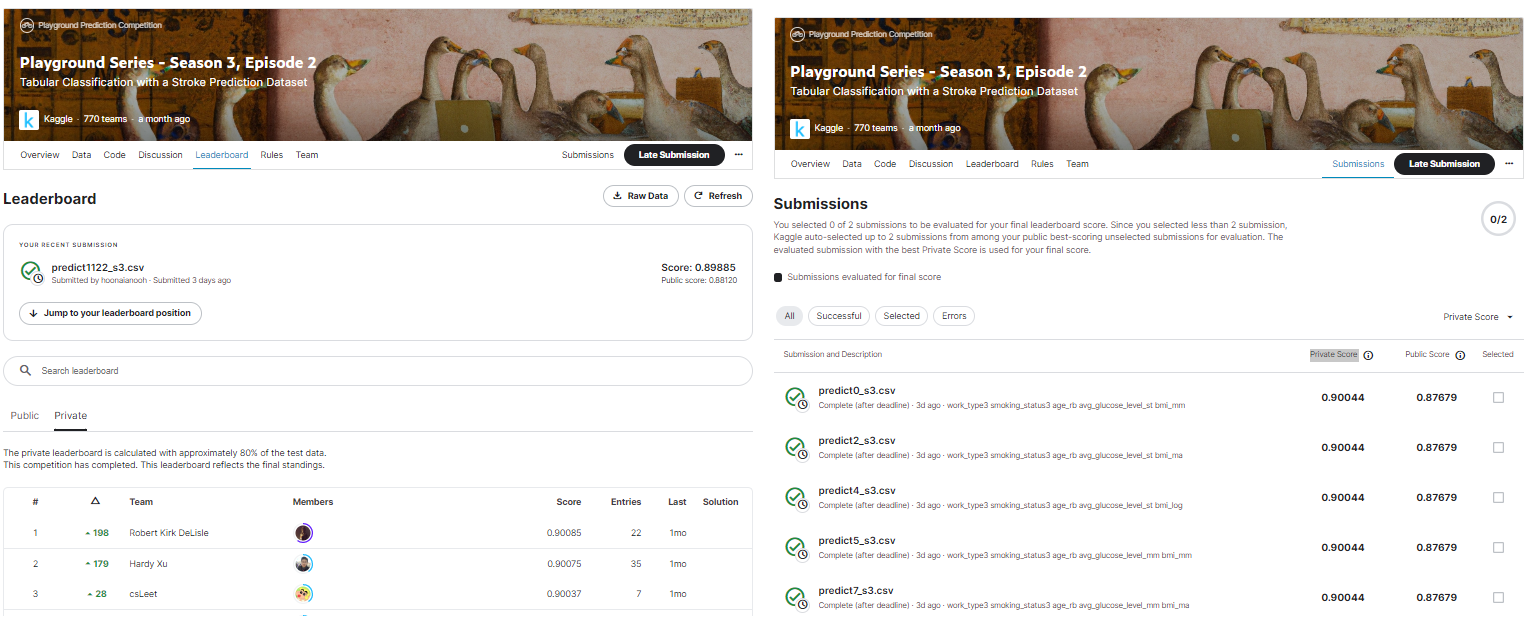)